# Value Lost

A notebook to determine the value lost when applying a maintenance strategy defined in an asset model to the population with an explanation of the steps to gee there.

Requested: greg.bell@essentialenergy.com.au
Author: gavin.treseder@essentialenergy.com.au

## Contents
1. Project Setup
2. Load Data
3. Simulation
4. Sensitivity


## Project Setup
Several steps need to be completed to get the project ready for analysis
### Current Working Directory
Set the file path so that we can import pof code and load files

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

### Import packages

Import the packages that are required for this process 

In [2]:
import copy

from IPython.display import clear_output
import numpy as np 
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as ss

from pof.system import System
from pof.interface import figures
from pof.interface.figures import make_sensitivity_fig
from pof.loader.asset_model_loader import AssetModelLoader
from pof.paths import Paths

%matplotlib inline

# Load Data
## Load the Asset Model
The asset model needs to be loaded from the excel file and converted into a component object that execute simulations

In [3]:
asset_model_filename = "Asset Model.xlsx"

paths = Paths()
model_path = paths.demo_path + os.sep + asset_model_filename

try:
    aml = AssetModelLoader()
    pof_data = aml.load(model_path)
    system = System.from_dict(pof_data['overhead_network'])
    comp = system.comp['pole']
    print("Asset Model loaded")
    pass
except:
    comp = Component.demo()
    print("Demo Model loaded")

Asset Model loaded


### Simulation - Single Event
See Failure Mode notebook

### Simulation - Monte Carlo 
The purpose of sensitivity is to understand the relationship between cost/risk/performance of a maintainence strategy when an input variable is changed. In previous notebooks we introduced the simulation concept and the outputs that can be produced. The length of time required to complete a sensitivity analysis is influenced by:
- t_end: the length of the time the each iteration is simulated to (sim time increases with t_end. Dependent on expected life and whether replacements occur)
- n_iterations: the number of iterations that are completed per simulation (sim time increases with n_iterations)
- model_units: the time units to use when completing a simmulation (sim time increases with smaller units)
The simulation is below has been set to complete quickly to demonstrate functionality

In [4]:
t_end = 100
n_iterations = 100
model_units = 'years'

In [5]:
comp.units = model_units
comp.mc_timeline(t_end=t_end, n_iterations=n_iterations)
comp.expected_risk_cost_df()
comp.plot_ms()

### Sensitivity
The purpose of sensitivity is to understand the relationship between cost/risk/performance of a maintainence strategy when an input variable is changed. It is influence by the following parameters
- var_id: the variable id for which sensitivity is going to be adjusted.
- lower: the lower limit for the var_id
- upper: the upper limit for the var_id
- step_size: the size of the increments that are going to be used
The length of time required to complete a sensitivity analysis is influenced by t_end, n_iterations and model_units. The simulation is below has been set to complete quickly to demonstrate functionality.

In [6]:
var_id = 'pole-task_group_name-groundline-t_interval'
lower = 0
upper = 10 
step_size = 1

In [7]:
comp.expected_sensitivity(var_id, lower, upper, step_size, n_iterations, t_end)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

## Determine Parameters that have the greatest impact
Considering the impact of all sensitivities at the same time results in a large computational burden. Considering the sensitivity of each parameters in isolation first allows parameters that have limited impact to be ignored and the focus shifted to high impact parameters.


In [21]:
#TODO update illyses code
# conf = 0.9
# n_increments = 10
# n_iterations = 100

# #if it's even add one
# df_sens = comp.sensitivity(var_name = df_inspection_slow, conf =  conf, n_increments = n_increments, n_iterations = n_iterations)

# comp.make_sensitivity_plot(
#     data = df_sens,
#     x_axis = 'conf',
#     y_axis = 'var_name',
#     failure_mode = 'slow_aging',
#     plot_type = 'heatmap',
#     z_axis = 'risk_cost',
# )

## Investigate the relationship between multiple parameters

There are often situations where the relationship between multiple parameters need to be considered at the same time. Creating a sesnitivity chain becomes computationally expensive so should only be considered for parameters that have a known impact.

- sens_vars: A dictionary of variables to chain with a list of values to evaluate.

The lists can be generated using three methods:
- [list][1]: a list of values to use
- [np.arange][2]: a list of numbers between *start* and *stop* at every *step* 
- [np.linspace][3]: a list of numbers between *start* and *stop* broken up into *num* increments

These three methods are equivalent:
~~~ python
sens_vars = {
    'var_list' : [0, 2, 4, 6, 8, 10],
    'var_arange' : np.arange(start = 0, stop = 11, step = 2), #parameter names are optional
    'var_linspace' : np.linspace(start = 0, stop = 10, num = 6) #parameter names are optional
}
~~~
[1]: https://docs.python.org/3/tutorial/datastructures.html
[2]: https://numpy.org/doc/stable/reference/generated/numpy.arange.html
[3]: https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace

In [8]:
sens_vars = {
    'pole-consequence-cost': np.arange(0, 2e6,5e5),
    'pole-task_group_name-groundline-t_interval': np.arange(0, 10, 1),
}
sens_vars

{'pole-consequence-cost': array([      0.,  500000., 1000000., 1500000.]),
 'pole-task_group_name-groundline-t_interval': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [9]:
df_sens_chain = comp.sensitivty_chain(sens_vars, t_end=t_end, n_iterations=n_iterations)
df_sens_chain.head()

### Rolling mean
Increasing the number of iterations to reduce the 'spikeiness' of the sensitivity charts is not always feasabily. To reduce simulation times, it can be beneficial to use a rolling mean to smooth out the profile and more easily identify trends, minimums or maximums.

In [28]:
x_var = var_id
y_var = 'pole-consequence-cost'
window=5

In [29]:
def rolling_mean(df, window=5, x_var:str, y_var:str):
    """ Returns a df with a rolling mean"""
    #TODO set this up so it work for 
    df_results = (
        df.copy(deep=True)
        .rename(columns={'task':'source'})
        .dropna()
    )

    # Generate a rolling average
    df_rolling = (
        df_results
        .sort_values(by=['source', x_var, y_var])
        .groupby(by=['source', y_var]).rolling(window).mean()
        .drop([y_var], axis=1)
        .reset_index()
        .dropna()
    )

    df_rolling['active'] = df_rolling['active'].astype(bool)

    return df_rolling


In [31]:
# Apply the function
df_rolling = rolling_mean(df_sens_chain, x_var=x_var, y_var=y_var,window=window)

# Create df_plot for generating a figure
df_plot = df_rolling.loc[df_rolling[y_var] == df_rolling.iloc[-1][y_var]]
df_plot.rename(columns={x_var : x_var.split('-')[-1]}, inplace=True)
make_sensitivity_fig(df_plot, var_name=x_var, y_axis = 'cost_cumulative')

In [48]:
def calc_value_lost(df, x_var:str, y_var:str):
    """ Takes a df of risk costs and returns a df with teh value lost
    # TODO move this to risk cost
    # TODO check y_var and x_var are the right way around
    """

    # Calculate the total cost for each scenario
    df = df_rolling.groupby(by=[x_var, y_var])['quantity', 'cost', 'quantity_annual', 'cost_annual'].sum()

    # Calculate the value_lost at each interval
    df['value_lost'] = df['cost'] - df.groupby(by=[y_var])['cost'].min()

    return df.reset_index()

In [49]:
df_total = calc_value_lost(df=df_rolling, x_var='pole-task_group_name-groundline-t_interval', y_var='pole-consequence-cost')

# Plot the results to check it works 
px.line(df_total.reset_index(), x='pole-task_group_name-groundline-t_interval', y = 'value_lost', color='pole-consequence-cost')

In [50]:
def make_contour_plot(df, x_axis, y_axis, z_axis):
    """ Create a contour plot """

    df_plot = df.reset_index()

    # Arrange the data for plotly
    z = df_plot.groupby(by = [x_axis])[z_axis].apply(lambda x: x.values.tolist()).tolist()
    x = df_plot[x_axis].unique()
    y = df_plot[y_axis].unique()

    # Generate the figure
    fig = go.Figure(
        data = go.Contour(x=x, y=y, z=z),#, contours_coloring='lines'),
    )

    fig.update_layout(
        xaxis_title=x_axis,
        yaxis_title=y_axis,
        legend_title=z_axis,
    )
    return fig

In [68]:
x_axis = 'pole-task_group_name-groundline-t_interval'
y_axis = 'pole-consequence-cost'
z_axis = 'value_lost'

make_contour_plot(df_total, x_axis=x_axis, y_axis=y_axis, z_axis=z_axis)

# Match Asset Models to the population
## Load the population data
The population data needs to be loaded with all the asset information that has been used to differentiate models

In [58]:
filename = r"C:\Users\gtreseder\OneDrive - KPMG\Documents\3. Client\Essential Energy\Probability of Failure Model\inputs\csvs\ACS - Poles - Consequence Model Output.csv"
print("File Loading...")
df_cons = pd.read_csv(filename)
clear_output()
df_cons.head()

,Unnamed: 0,ASSET_ID,Depot (ZSG Area),Pole_LU_NSWMajo,Pole_LU_NSWDeta,Pole_LU_ALUMMaj,Pole_LU_ALUMDet,Road Crossing Conductor Type,HV_LV Status,BushfirePriority,...,C_Environment_Rank,Site_Bushfire_Moderate_Probability,Site_Bushfire_Severe_Probability,C_Bushfire_Dollars,Site_Environment_Insignificant_Probability,Site_Environment_Minor_Probability,C_Environment_Dollars,C_Financial_Dollars,Total Consequence $,Radial(Y/N)
0,0,388,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2802.19134,21198.144867,NaN
1,1,389,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2802.57978,21198.533307,NaN
2,2,390,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2803.09692,21199.050447,NaN
3,3,391,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2803.76382,21199.717347,NaN
4,4,392,Cobar Depot,Grazing,Rangeland grazing,Grazing native vegetation,Grazing native vegetation,None,HV Only,P3,...,5,0.000715,0.000005,755.419255,0.0,0,0,2804.33010,21200.283627,NaN


## Match to the closest model
Each asset needs to be matched with the model that most closely represents it's parameters. This requires transforming the columns to align with the 

In [59]:
# TODO turn ino a function so it works for mutliple y vars

pop_var = 'Total Consequence $'
sens_var = 'pole-consequence-cost'
df_sens_var = pd.DataFrame(sens_vars[sens_var], columns= [sens_var])

# Fill with average val
df_cons[pop_var] = df_cons[pop_var].fillna(df_cons[pop_var].mean())

# Match to the closest value from the model
df = pd.merge_asof(
    df_cons.sort_values(pop_var),
    df_sens_var,
    left_on = pop_var,
    right_on = sens_var,
    direction = 'forward'
)

MemoryError: Unable to allocate 160. MiB for an array with shape (15, 1400157) and data type object

## Remove uncessary columns
Computational time can be increased by removing information that isn't needed

In [ ]:
#TODO generalise to work for any columns
uid_col = 'ASSET_ID'
agg_cols = ['Depot (ZSG Area)']
interesting_cols = []
col_to_keep = [uid_col] + agg_cols + [pop_var] + [sens_var] + interesting_cols

df = df[col_to_keep]
df.head()

### Count assets within each subpopluation
To speed up execution the code, the number of assets within each group can be combined 

In [ ]:
by = agg_cols + [sens_var]
df_pop = df.groupby(by=by)[uid_col].count().reset_index().rename(columns={uid_col:'asset_count'})
df_pop.head()

In [ ]:
index = agg_cols[0]
columns = sens_var
idx_sample = df_pop[index].sample(10).unique()[:4]

consequence = df_pop.pivot_table(index=index, columns= columns, values = 'asset_count', aggfunc=sum).fillna(0).astype(int)
consequence.loc[idx_sample].plot(kind='barh', title=f'{index} by {columns}');

In [63]:
df_value_lost = pd.merge(df_pop, df_total, on=sens_var)

by = agg_cols + [sens_var] + [x_var]
df_value_lost.groupby(by)['value_lost'].sum().reset_index()

,Depot (ZSG Area),pole-consequence-cost,pole-task_group_name-groundline-t_interval,value_lost
0,Albury Depot,200000.0,6.0,0.20
1,Albury Depot,200000.0,9.0,0.16
2,Albury Depot,200000.0,12.0,0.14
3,Albury Depot,200000.0,15.0,0.14
4,Albury Depot,200000.0,18.0,0.10
...,...,...,...,...
15475,[ Deleted Assets ],1400000.0,99.0,0.10
15476,[ Deleted Assets ],1400000.0,102.0,0.02
15477,[ Deleted Assets ],1400000.0,105.0,0.03
15478,[ Deleted Assets ],1400000.0,108.0,0.00


In [64]:
df_total

,pole-task_group_name-groundline-t_interval,pole-consequence-cost,quantity,cost,quantity_annual,cost_annual,value_lost
0,6.0,0.0,1.9960,56.72,0.019817,0.563142,0.16
1,6.0,200000.0,1.9964,256.76,0.019822,2.549313,0.20
2,6.0,400000.0,1.9938,619.40,0.019822,6.161602,162.87
3,6.0,600000.0,1.9938,899.39,0.019836,8.950019,242.88
4,6.0,800000.0,1.9960,1018.11,0.019822,10.111483,161.61
...,...,...,...,...,...,...,...
355,111.0,1000000.0,1.9954,1258.09,0.019828,12.501391,201.56
356,111.0,1200000.0,1.9954,1256.70,0.019815,12.479765,0.07
357,111.0,1400000.0,1.9920,1737.92,0.019828,17.294819,281.37
358,111.0,1600000.0,1.9948,1978.05,0.019813,19.648209,321.49


In [65]:
df_value_lost

,Depot (ZSG Area),pole-consequence-cost,asset_count,pole-task_group_name-groundline-t_interval,quantity,cost,quantity_annual,cost_annual,value_lost
0,Albury Depot,200000.0,17860,6.0,1.9964,256.76,0.019822,2.549313,0.20
1,Albury Depot,200000.0,17860,9.0,1.9956,256.72,0.019825,2.550287,0.16
2,Albury Depot,200000.0,17860,12.0,1.9952,256.70,0.019820,2.549967,0.14
3,Albury Depot,200000.0,17860,15.0,1.9952,256.70,0.019824,2.550469,0.14
4,Albury Depot,200000.0,17860,18.0,1.9948,256.66,0.019821,2.550314,0.10
...,...,...,...,...,...,...,...,...,...
15475,Tweed Heads Depot,1800000.0,2,99.0,1.9906,1856.50,0.019811,18.476426,0.00
15476,Tweed Heads Depot,1800000.0,2,102.0,1.9932,2217.97,0.019816,22.051639,361.47
15477,Tweed Heads Depot,1800000.0,2,105.0,1.9916,2217.92,0.019810,22.060608,361.42
15478,Tweed Heads Depot,1800000.0,2,108.0,1.9932,2217.99,0.019819,22.054740,361.49


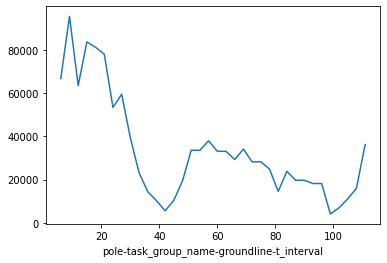

In [67]:
df_value_lost.groupby(by=x_var).sum()['value_lost'].plot();

## Insights
Insights should be run with an emphasis on accuracy rather than simulation time and have each been set up with high iteration counts

### Impact of improving inspection effectiveness

In [ ]:
var_id = 'pole-task_group_name-inspection_groundline-p_effective'
comp.expected_sensitivity(var_id = var_id, lower = 0.1, upper = 1, step_size= 0.1, n_iterations=1000, t_end=100)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

### Min effectiveness for Pole Saver Rod

In [ ]:
# Turn on Pole Saver Rod
comp.fm['fungal decay | internal'].tasks['pole_saver_rod'].active = True

# Run simulation
var_id = 'pole-task_group_name-inspection_groundline-p_effective'
comp.expected_sensitivity(var_id = var_id, lower = 0.1, upper = 1, step_size= 0.1, n_iterations=1000, t_end=100)
clear_output()
comp.plot_sens(var_id=var_id, y_axis='cost_cumulative')

# Turn off Pole Saver Rod
comp.fm['fungal decay | internal'].tasks['pole_saver_rod'].active = False

## Long run simulation 
Run a long simulation to repeat the process above for the key outputs without the interim steps

In [73]:
# Set the parameters
t_end = 100 * 12
n_iterations = 100
model_units = 'months'
sens_vars = {
    'pole-consequence-cost': np.arange(0, 2e6, 2e5),
    'pole-task_group_name-groundline-t_interval': np.arange(0, 120, 3)
}

x_var = 'pole-task_group_name-groundline-t_interval'
y_var = 'pole-consequence-cost'
z_var = 'value_lost'

pop_var = 'Total Consequence $'

window=5

In [74]:
# Run the simulation
comp.units = model_units

df_sens_chain = comp.sensitivty_chain(sens_vars, t_end=t_end, n_iterations=n_iterations)

df_rolling = rolling_mean(df_sens_chain, window=window)

df_total = calc_value_lost(df=df_rolling, x_var='pole-task_group_name-groundline-t_interval', y_var='pole-consequence-cost')

In [57]:
df_sens_var = pd.DataFrame(sens_vars[y_var], columns= [y_var])

# Fill with average val
df_cons[pop_var] = df_cons[pop_var].fillna(df_cons[pop_var].mean())

# Match to the closest value from the model
df = pd.merge_asof(
    df_cons.sort_values(pop_var),
    df_sens_var,
    left_on = pop_var,
    right_on = y_var,
    direction = 'forward'
)

df_plot = pd.merge(df, df_total.reset_index(), on=y_var).groupby(by=x_var).sum().reset_index()
#y= ['list(set(df_plot) - set([sens_var, uid_col]))']
y = ['quantity_annual', 'cost_annual', 'value_lost']

px.line(df_plot, x=x_var, y=y)

MemoryError: Unable to allocate 385. MiB for an array with shape (50403348,) and data type int64

In [36]:
depots = ['Young Depot', 'Temora Depot', 'Yass Depot', 'Young Depot', 'Bathurst Depot']